In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.svm import SVR
from itertools import product

In [4]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
X_train, X_test, y_train, y_test = train_test_split(*make_classification(n_samples=10000,n_features=200))

In [2]:
parameter_space = {'n_estimators':[2,200],
                  'max_depth':[2,40],}
#                   'min_samples_split':[2,100],
#                   'min_samples_leaf':[2,200],
#                   }
  

In [25]:
class Minesweeper:
    def __init__(self, parameter_space):
        self.b = 3
        self.df = pd.DataFrame(columns=parameter_space.keys())
        self.df['score'] = []
        self.mms = MMS().fit(pd.DataFrame(parameter_space))
        self.dimensions = len(parameter_space)
        
    @property
    def bins(self):
        return np.linspace(0,1,self.b+1)
    
    def get_parameters(self):
        scores = self.df.pop('score')
        while True:
            all_cells = set(product(list(range(self.b)), repeat=self.dimensions))
            occupied_cells = list(set(self.df.apply(lambda x:np.digitize(x, self.bins)-1, 
                                           result_type='reduce', axis =1).apply(tuple)))
        
            relative_neighbors = (list(product((-1,0,1), repeat=self.dimensions)))
            exclude_cells = list(set([(tuple([i+j for i,j in zip(a,b)])) 
                                      for b in relative_neighbors for a in occupied_cells]))
            exclude_cells = set([x for x in exclude_cells if all(0<=i<self.b for i in x)])
        
            vacant_cells = list(all_cells-exclude_cells)
            if len(vacant_cells)==0:
                self.b+=1
                continue
                
            chosen_cell = vacant_cells[np.random.randint(0,len(vacant_cells))]
            chosen_values = tuple([(self.bins[i]+self.bins[i+1])/2 for i in chosen_cell])
            self.df['score']=scores
            return {k:v for k,v in zip(self.mms.feature_names_in_,
                                       self.mms.inverse_transform([chosen_values])[0])}
        
    def update_values(self,values,score):
        values = pd.DataFrame(values, index=[0])
        values = pd.DataFrame(data=self.mms.transform(values), columns=values.columns)
        values['score'] = score
        
        self.df = pd.concat([self.df, values], ignore_index=True).reset_index(drop=True)
        
        
    def best_parameters(self,full=False):
        if len(self.df)<2: return self.get_parameters()
        X = (self.df if full else self.df.sample(frac=1/np.e)).copy()
        y = X.pop('score')
        svr = SVR().fit(X,y)
        observations = 100_000 if full else 1000
        predict_X = pd.DataFrame(columns=X.columns, data=np.random.uniform(size=(observations,X.shape[1])))
        predictions = svr.predict(predict_X)
        return {k:v for k,v in zip(self.mms.feature_names_in_, 
                                   self.mms.inverse_transform([predict_X.loc[predictions.argmax()]]).flatten())}

In [26]:
ms = Minesweeper(parameter_space)

In [57]:
for i in range(100):
    if i%3==1:
        values = ms.best_parameters()
    else:
        values = ms.get_parameters()
    values = {k:int(v) for k,v in values.items()}
    print(values)
    rfc = RFC(**values).fit(X_train,y_train)
    score = f1_score(y_test, rfc.predict(X_test))
    print(score)
    ms.update_values(values, score)
ms.df

{'n_estimators': 100, 'max_depth': 4}
0.8845553822152886
{'n_estimators': 132, 'max_depth': 37}
0.8949044585987261
{'n_estimators': 88, 'max_depth': 37}
0.8917299240910906
{'n_estimators': 138, 'max_depth': 23}
0.8940055577610163
{'n_estimators': 191, 'max_depth': 36}
0.8944643568299483
{'n_estimators': 57, 'max_depth': 25}
0.89171974522293
{'n_estimators': 100, 'max_depth': 21}
0.8902147971360381
{'n_estimators': 14, 'max_depth': 37}
0.8858520900321544
{'n_estimators': 57, 'max_depth': 16}
0.8924176260420803
{'n_estimators': 130, 'max_depth': 7}
0.8881889763779529
{'n_estimators': 154, 'max_depth': 6}
0.8839779005524863
{'n_estimators': 130, 'max_depth': 30}
0.8922585794094173
{'n_estimators': 190, 'max_depth': 26}
0.8963317384370018
{'n_estimators': 111, 'max_depth': 3}
0.8880980624752868
{'n_estimators': 11, 'max_depth': 26}
0.8875645609853
{'n_estimators': 130, 'max_depth': 15}
0.8920634920634921
{'n_estimators': 97, 'max_depth': 25}
0.8966892700438772
{'n_estimators': 190, 'max_de

,n_estimators,max_depth,score
0,0.166667,0.815789,0.893157
1,0.828283,0.157895,0.886185
2,0.828283,0.815789,0.894024
3,0.166667,0.157895,0.886409
4,0.828283,0.000000,0.880315
...,...,...,...
105,0.974747,0.105263,0.885917
106,0.247475,0.815789,0.891270
107,0.080808,0.026316,0.887212
108,0.883838,0.868421,0.893583


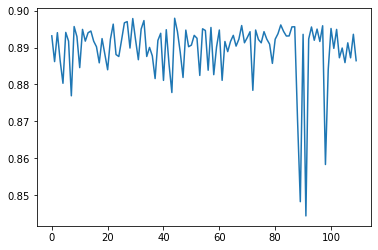

In [58]:
plt.plot(ms.df.index, ms.df['score']);

In [59]:
ms.df.sort_values('score',ascending=False)

,n_estimators,max_depth,score
44,0.530303,0.500000,0.897927
29,0.196970,0.710526,0.897845
33,0.787879,0.947368,0.897293
27,0.949495,0.315789,0.897018
26,0.479798,0.605263,0.896689
...,...,...,...
7,0.015152,0.894737,0.876929
88,0.020202,0.447368,0.870607
98,0.020202,0.710526,0.858326
89,0.005051,0.342105,0.848265


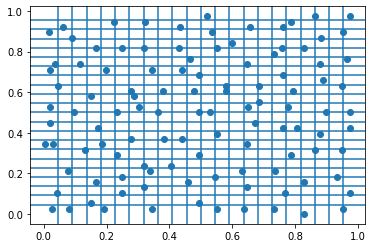

In [60]:
plt.scatter(ms.df.iloc[:,0],ms.df.iloc[:,1])
[(plt.axhline(b), plt.axvline(b)) for b in ms.bins[1:-1]];
# plt.scatter(ms.df.iloc[:,2],ms.df.iloc[:,3])

In [61]:
ms.best_parameters(full=True)

{'n_estimators': 116.78168898351154, 'max_depth': 30.62414556509424}

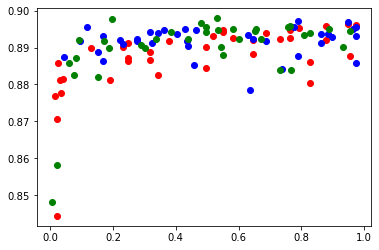

In [74]:
plt.scatter(ms.df.iloc[1::3,0], ms.df['score'][1::3], color = 'red')
plt.scatter(ms.df.iloc[0::3,0], ms.df['score'][0::3], color='blue')
plt.scatter(ms.df.iloc[2::3,0], ms.df['score'][2::3], color='green')

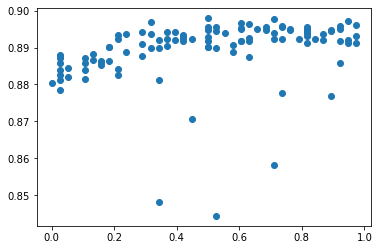

In [63]:
plt.scatter(ms.df.iloc[:,1], ms.df['score'])

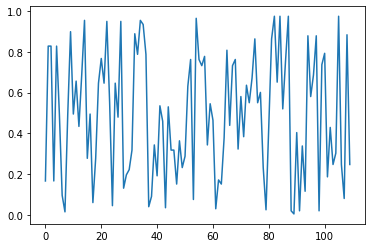

In [70]:
plt.plot(ms.df.iloc[:,0])

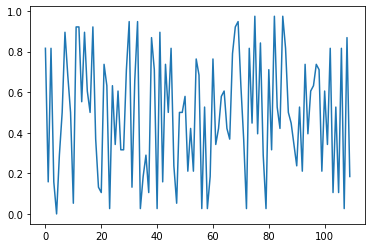

In [69]:
plt.plot(ms.df.iloc[:,1])